# Neural Networks and VAEs

In this notebook, we will explore automatic differentiation, neural networks, and amortized variational inference. PyTorch makes it easy to construct such networks and train them with backpropagation. We'll give you a few examples to help get you started.



In [ ]:
import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

## Part 1: Regression with Deep Neural Networks

We'll start off with a simple regressoin problem: train a neural network to approximate the function $f(x) = \sin(x)$. We'll give the network lots of noisy observations $(x_n, y_n)$ where $y_n \sim \mathcal{N}(f(x_n), \sigma^2)$. We'll use a simple feedforward network and train it with SGD.

### Simulate data

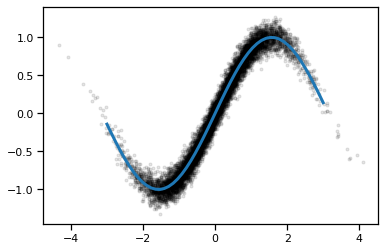

In [ ]:
# Construct the dataset
torch.manual_seed(0)
N = 10000
sigma = 0.1
xs = torch.randn(N)
ys = torch.sin(xs) + sigma * torch.randn(N)

x_grid = torch.linspace(-3, 3, 50)
plt.plot(xs, ys, 'k.', alpha=0.1)
plt.plot(x_grid, torch.sin(x_grid), lw=3)

### Construct a feedforward neural network

This code implements a simple feedforward neural network class that inherits from `nn.Module`. Modules implement a `forward` function that maps inputs to outputs. The class variables (`self.fc1` and `self.fc2` are Modules themselves, each with their own parameters. When it comes to training the network, we can use the `parameters()` function to get the list of trainable parameters - this function introspects on each of the class variables and extracts the parameters associated with each layer.

_Note:_ for simple networks like this one, PyTorch offers a [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) object that saves you a few lines of code. Here we've built the module from scratch to show the more general approach. We'll extend this module in Part 2.

In [ ]:
class SimpleNet(nn.Module):
    """A simple feedforward neural network
    """

    def __init__(self, layer_size=20):
        super().__init__()
        
        # Construct linear "fully connected" (fc) layers
        self.fc1 = nn.Linear(in_features=1, out_features=layer_size)
        self.fc2 = nn.Linear(in_features=layer_size, out_features=1)

    def forward(self, x):
        """ Implements the forward pass of the network.

        Args:
            x: torch.tensor of shape (N,)
        Returns:
            z: torch.tensor of shape (N,) containing the logits
        """
        # Note we have to unsqueeze the inputs to make them explicitly 1D
        h1 = F.relu(self.fc1(x.unsqueeze(1)))
        # Note we have to squeeze the outputs to make them explicitly 0D
        preds = self.fc2(h1).squeeze(1)
        return preds

# Construct an instance of the model. It will be given with random weights 
# per PyTorch's default initialization strategy.
model = SimpleNet()

### Plot the predictions of the randomly initialized model

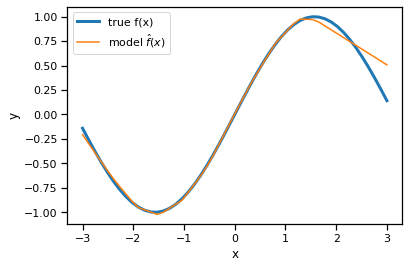

In [ ]:
plt.plot(x_grid, torch.sin(x_grid), lw=3, label="true f(x)")
plt.plot(x_grid, model.forward(x_grid).detach(), label="model $\hat{f}(x)$") 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### Optimize the model parameters to maximize the likelihood

The log likelihood in this model is,

$$
\begin{align}
\log p(\mathbf{y} \mid \mathbf{x}, \theta, \sigma^2) 
&= \sum_{n=1}^N \log \mathcal{N}(y_n \mid f(x_n; \theta), \sigma^2) \\
&= -\frac{1}{2\sigma^2} \sum_{n=1}^N \| y_n - f(x_n; \theta) \|_2^2 + c
\end{align}
$$

where $f: \mathbb{R} \mapsto \mathbb{R}$ is a neural network with parameters $\theta$. 

Maximizing the log likelihood is equivalent to **minimizing the mean squared error**,

$$
\begin{align}
\mathcal{L}(\theta) &= \frac{1}{N} \sum_{n=1}^N \| y_n - f(x_n; \theta) \|_2^2 
\end{align}
$$

The code below minimizes this objective using Adam, a stochastic optimization algorithm.

In [ ]:
# Next we define a loss function to minimize. In our case, we want this 
# to be related to the log likelihood of ys given xs, which is proportional
# to the mean squared error of the predictions.
loss_fn = torch.nn.MSELoss(reduction='mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
num_iters = 2000
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(num_iters):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xs)

    # Compute and print loss.
    loss = loss_fn(y_pred, ys)
    if t % 100 == 99:
        print("Iter", t, ": ", loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

Iter 99 :  0.05827584117650986
Iter 199 :  0.026369161903858185
Iter 299 :  0.021391645073890686
Iter 399 :  0.019107051193714142
Iter 499 :  0.01772165112197399
Iter 599 :  0.016685152426362038
Iter 699 :  0.015853283926844597
Iter 799 :  0.015168149024248123
Iter 899 :  0.014585076831281185
Iter 999 :  0.014068115502595901
Iter 1099 :  0.01361026894301176
Iter 1199 :  0.013216633349657059
Iter 1299 :  0.012868551537394524
Iter 1399 :  0.012556979432702065
Iter 1499 :  0.012282115407288074
Iter 1599 :  0.012035701423883438
Iter 1699 :  0.011812495067715645
Iter 1799 :  0.011609983630478382
Iter 1899 :  0.011424396187067032
Iter 1999 :  0.011261513456702232


## Plot the trained model's predictions

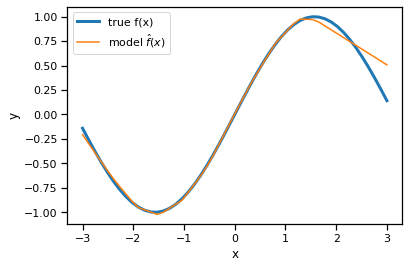

In [ ]:
x_grid = torch.linspace(-3, 3, 50)
y_pred = model.forward(x_grid)

# We have to "detach" the predictions from the computation graph
# before we can plot them.
y_pred = y_pred.detach()

plt.plot(x_grid, torch.sin(x_grid), lw=3, label="true f(x)")
plt.plot(x_grid, y_pred, label="model $\hat{f}(x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Exercises

1. Add another layer to the SimpleNet
2. Try predicting beyond the range of the training data. What do the predictions look like?
3. Swap out the rectified linear (relu) activation with another nonlinearity, like the sigmoid or the GELU activation.
4. Try different optimizers (SGD with and without momentum, RMSProp)


## Part 2: Variational Autoencoders

In this section, we will train a variational autoencoder for a simple synthetic data. This is essentially a generalization of the sinusoidal regression problem from above. Here, the data is generated from,

$$
\begin{align}
z_n &\sim \mathcal{N}(0, 1) \\
x_n &\sim \mathcal{N}(f(z_n), \sigma^2 I) 
\end{align}
$$

where 

$$
\begin{align}
f(z) = \begin{bmatrix} \cos(z) \\ \sin(z) \end{bmatrix}
\end{align}
$$

Thus, the data is essentially lives near a 1D nonlinear manifold (here, a circle).

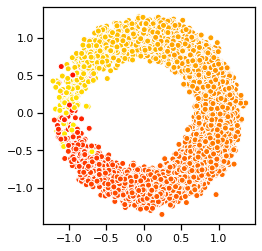

In [ ]:
# Construct the dataset
torch.manual_seed(0)
N = 20000
sigma = 0.1
zs = torch.randn(N)
xs = torch.column_stack([torch.cos(zs), 
                         torch.sin(zs)]) + sigma * torch.randn((N, 2))

x_grid = torch.linspace(-3, 3, 50)
plt.scatter(xs[:,0], xs[:,1], c=zs, cmap="autumn", ec='w')
plt.gca().set_aspect("equal")

### Make a simple data loader for this dataset

Data loaders are convenience wrappers for iterating over minibatches of data points.

In [ ]:
train_dataloader = DataLoader(xs[:(3*N//4)], batch_size=1000, shuffle=True)
test_dataloader = DataLoader(xs[(3*N//4):], batch_size=1000, shuffle=True)

### Part 2a: Decoder Network

Implemen+t a decoder that maps $\mathbb{R} ↦ \mathbb{R}^2$ with a 2 layer decoder.

In [ ]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[20, 20], noise_scale=0.1):
        super().__init__()
        self.data_dim = data_dim
        self.noise_scale = noise_scale

        self.fc1 = nn.Linear(latent_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], data_dim)

    def forward(self, z):
        """ Computes means of p(x | z).
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Normal distribution
        """
        h1 = F.relu(self.fc1(z))
        h2 = F.relu(self.fc2(h1))
        preds = self.fc3(h2)
        return Normal(preds, self.noise_scale)

### Problem 2b: Encoder Network

We will estimate the parameters of the generative model by maximizing the Evidence Lower Bound (ELBO). As the exact posterior $p(\mathbf{z} \mid \mathbf{x})$ is unknown, we will use an approximate, amortized posterior $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}(\mathbf{z} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}), \text{diag}(\sigma^2_{\boldsymbol{\phi}}(\mathbf{x})))$. We let $\left(\mu_{\boldsymbol{\phi}}(\mathbf{x}), \log \sigma^2_{\boldsymbol{\phi}}(\mathbf{x}) \right) = E_{\boldsymbol{\phi}}(\mathbf{x})$ where $E_{\boldsymbol{\phi}}: \mathbb{R}^{2} \to \mathbb{R}^1 \times \mathbb{R}^1$ is a neural network with parameters $\boldsymbol{\phi}$. 

As above, we parametrize $E_{\boldsymbol{\phi}}$ as a neural network with two layers of hidden units and ReLU activations. We use 20 hidden units in the first layer and 20 in the second. Then we let $\mu_{\boldsymbol{\phi}}$ and $\log \sigma^2_{\boldsymbol{\phi}}$ be affine functions of the hidden layer activations. Implement the encoder $E_{\boldsymbol{\phi}}$ in the code below.

In [ ]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[20, 20]):
        super().__init__()
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(data_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc31 = nn.Linear(hidden_dims[1], latent_dim)
        self.fc32 = nn.Linear(hidden_dims[1], latent_dim)

    def forward(self, x):
        """ Computes normal distribution q(z | x)

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution
        """
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        means = self.fc31(h2)
        log_sigmasqs = self.fc32(h2)
        sigmas = torch.exp(0.5 * log_sigmasqs)
        return Normal(means, sigmas)

### Problem 2c: Implement the ELBO


In class we derived the local ELBO and showed that it can be written as the **expected log likelihood** minus the **KL divergence to the prior**. With the reparameterization trick for a Gaussian variational posterior, this is:

$$
\begin{align*}
\mathcal{L}_n(\boldsymbol{\theta}, \boldsymbol{\phi}) 
&= \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}_n \mid \mathbf{x}_n)} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}_n \mid \mathbf{z}_n) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z}_n \mid \mathbf{x}_n) \mid\mid p(\mathbf{z}_n)\right) \\
&= \mathbb{E}_{\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}_n \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}_n) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x}_n)) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z}_n \mid \mathbf{x}_n) \mid\mid p(\mathbf{z}_n)\right)
\end{align*}
$$

(Though we have written the local ELBO as a function of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ only, note that it is of course also a function of the data point $\mathbf{x}_n$.


Implement the estimator of the ELBO $\hat{\mathcal{L}}(\boldsymbol{\theta}, \boldsymbol{\phi})$. We assume sampling of the data point (or minibatch of data points) `x` is done outside of the function, but you must sample the noise variables $\boldsymbol{\epsilon}$ within the `elbo` function. You should use the `kl_divergence` function imported above to analytically compute the KL divergence between the Gaussian distributions $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})$ and $p(\mathbf{z})$. Make sure you use `rsample` on a `Distribution` object to use the reparametrization trick and not `sample`.

In [ ]:
def elbo(x, encoder, decoder):
    """ Computes a stochastic estimate of the rescaled evidence lower bound

    Args:
        x: (N, data_dim) torch.tensor
        encoder: an Encoder
        decoder: a Decoder
    Returns:
        elbo: a (,) torch.tensor containing the estimate of the ELBO
    """
    p_z = Normal(0, 1)
    q_z = encoder.forward(x)
    
    # eps = Normal(0, 1).sample()
    # z = q_z.mean + q_z.scale * eps
    
    z = q_z.rsample()
    elbo = decoder.forward(z).log_prob(x).sum(dim=1).mean(dim=0)
    elbo -= kl_divergence(q_z, p_z).sum(dim=1).mean(dim=0)
    return elbo

### Implement the Training Loop [given]

Using our `Encoder` and `Decoder` definitions, as well as the `elbo` function, we have provided training code below. This code uses the [Adam](https://arxiv.org/abs/1412.6980) optimizer, an optimization algorithm which uses the history of past gradients to rescale gradients before applying an update.

In [ ]:
encoder = Encoder(data_dim=2, latent_dim=1)
decoder = Decoder(data_dim=2, latent_dim=1)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=3e-4)

num_epochs = 500

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_elbo = 0
    for batch_idx, x in enumerate(train_dataloader):
        optimizer.zero_grad()

        loss = -elbo(x, encoder, decoder)  
        loss.backward()
        train_elbo -= loss.item() * len(x)
        optimizer.step()
            
    encoder.eval()
    decoder.eval()
    test_elbo = 0
    with torch.no_grad():
        for x in test_dataloader:
            test_elbo += elbo(x, encoder, decoder).item() * len(x)
            
    train_elbo /= len(train_dataloader.dataset)
    test_elbo /= len(test_dataloader.dataset)
    
    if epoch % 10 == 0:
        print('====> Epoch: {} Average ELBO: {:.4f} Test ELBO: {:.4f}'.format(
            epoch, train_elbo, test_elbo))


====> Epoch: 0 Average ELBO: -45.5057 Test ELBO: -42.9813
====> Epoch: 10 Average ELBO: -29.9157 Test ELBO: -29.5217
====> Epoch: 20 Average ELBO: -18.1990 Test ELBO: -16.9383
====> Epoch: 30 Average ELBO: -7.9992 Test ELBO: -7.7047
====> Epoch: 40 Average ELBO: -4.3742 Test ELBO: -4.4065
====> Epoch: 50 Average ELBO: -3.0742 Test ELBO: -3.2804
====> Epoch: 60 Average ELBO: -2.5324 Test ELBO: -2.7229
====> Epoch: 70 Average ELBO: -2.1998 Test ELBO: -2.3630
====> Epoch: 80 Average ELBO: -1.9565 Test ELBO: -2.1643
====> Epoch: 90 Average ELBO: -1.7907 Test ELBO: -1.9636
====> Epoch: 100 Average ELBO: -1.6485 Test ELBO: -1.8697
====> Epoch: 110 Average ELBO: -1.5719 Test ELBO: -1.8176
====> Epoch: 120 Average ELBO: -1.4992 Test ELBO: -1.6952
====> Epoch: 130 Average ELBO: -1.4576 Test ELBO: -1.6657
====> Epoch: 140 Average ELBO: -1.3984 Test ELBO: -1.5892
====> Epoch: 150 Average ELBO: -1.3585 Test ELBO: -1.5678
====> Epoch: 160 Average ELBO: -1.3289 Test ELBO: -1.5371
====> Epoch: 170 Av

### Problem 2d: Visualize samples from the trained model

In addition to the ELBO, we can sample from the trained model to assess its performance. Use the code below to generate an $8 \times 8$ grid of sampled digits from the model. Note that we follow the common practice of using the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$ rather than resampling from this distribution when visualizing samples. Critique these samples. What aspects of the data distribution does the model seem to have trouble learning?

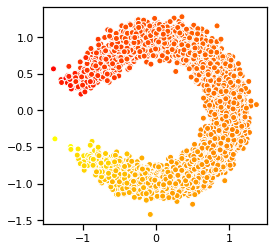

In [ ]:
# Visualize sampled digits from our model
decoder.eval()
with torch.no_grad():
    z = torch.randn(10000,1)
    samples = decoder.forward(z).sample()
    
plt.scatter(samples[:, 0], samples[:, 1], c=z[:, 0], cmap="autumn", ec='w')
plt.gca().set_aspect(1)